In [1]:
import json, cv2
import numpy as np
from utils import plot_images

In [6]:
image_dir = "/workspace/FishEye8k/dataset/Fisheye8K_all_including_train/test/images/"
gt_dir    = "/workspace/FishEye8k/dataset/Fisheye8K_all_including_train/test/test.json"

In [7]:
pred_dir  = "results/internimage_eval_fisheye_128.json"

In [8]:
with open(gt_dir)   as f: gts   = json.load(f)
with open(pred_dir) as f: preds = json.load(f)

In [9]:
gt_img, gt_ann = gts["images"], gts["annotations"]

# get all image_id from the predicitons
img_ids = []
for pred in preds:
  if not pred["image_id"] in img_ids: 
    img_ids.append(pred["image_id"])

camera4_E_237.png


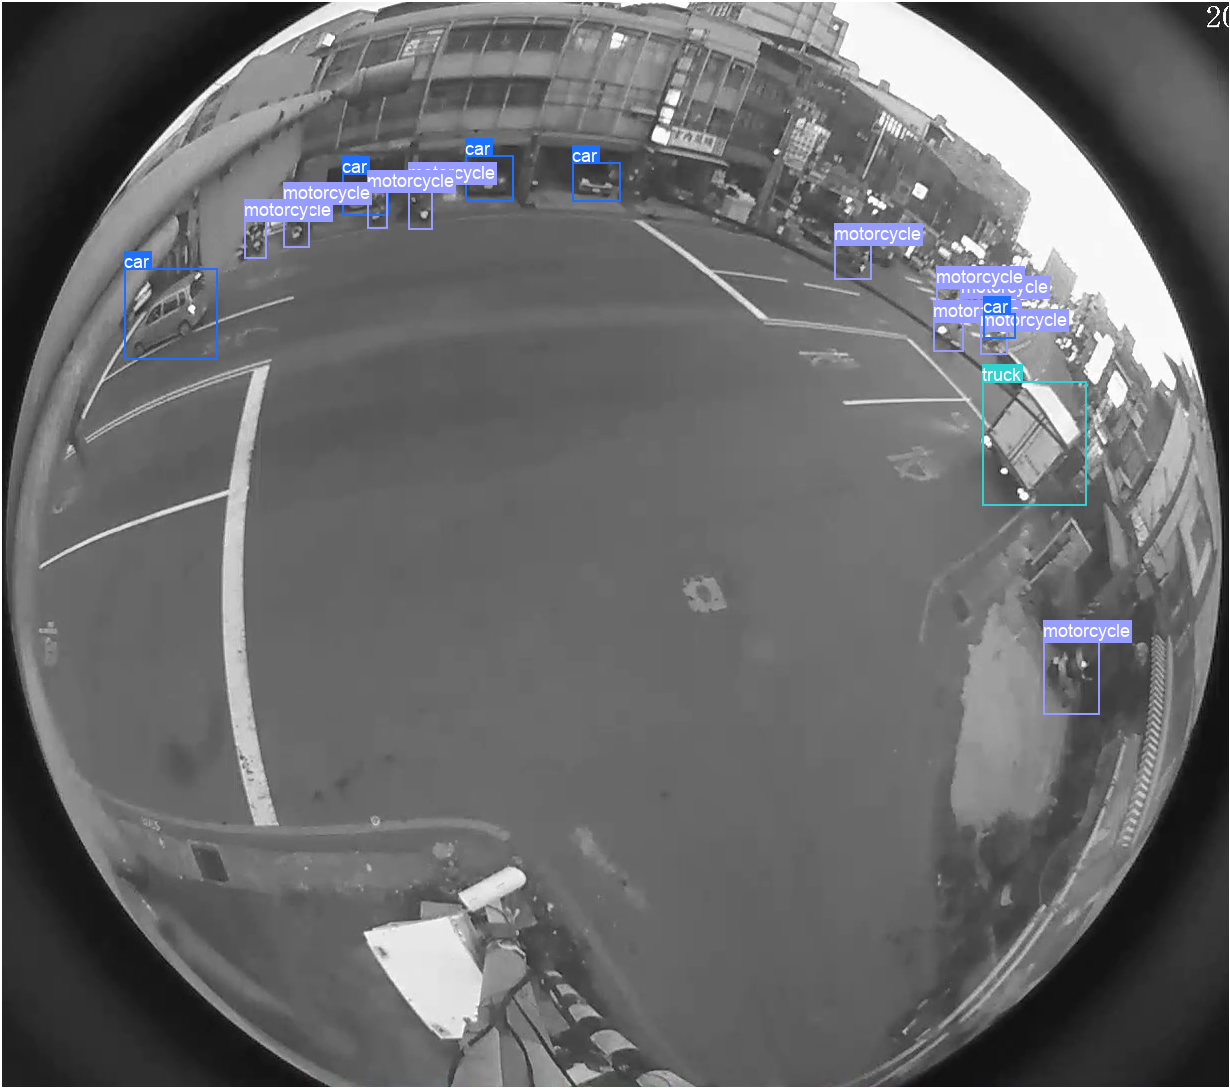

In [10]:
idx = img_ids[20]

filename = [g["file_name"] for g in gt_img if g["id"] == idx]
print(filename[0])
img = cv2.imread(image_dir + filename[0])

# get ground truth
cls = np.array([gt["category_id"] for gt in gt_ann if gt["image_id"] == idx])
bboxes = np.array([gt["bbox"] for gt in gt_ann if gt["image_id"] == idx])
names = {0: 'bus', 1: 'motorcycle', 2: 'car', 3: 'person', 4: 'truck'}

plot_images(img, cls, bboxes, None, names)

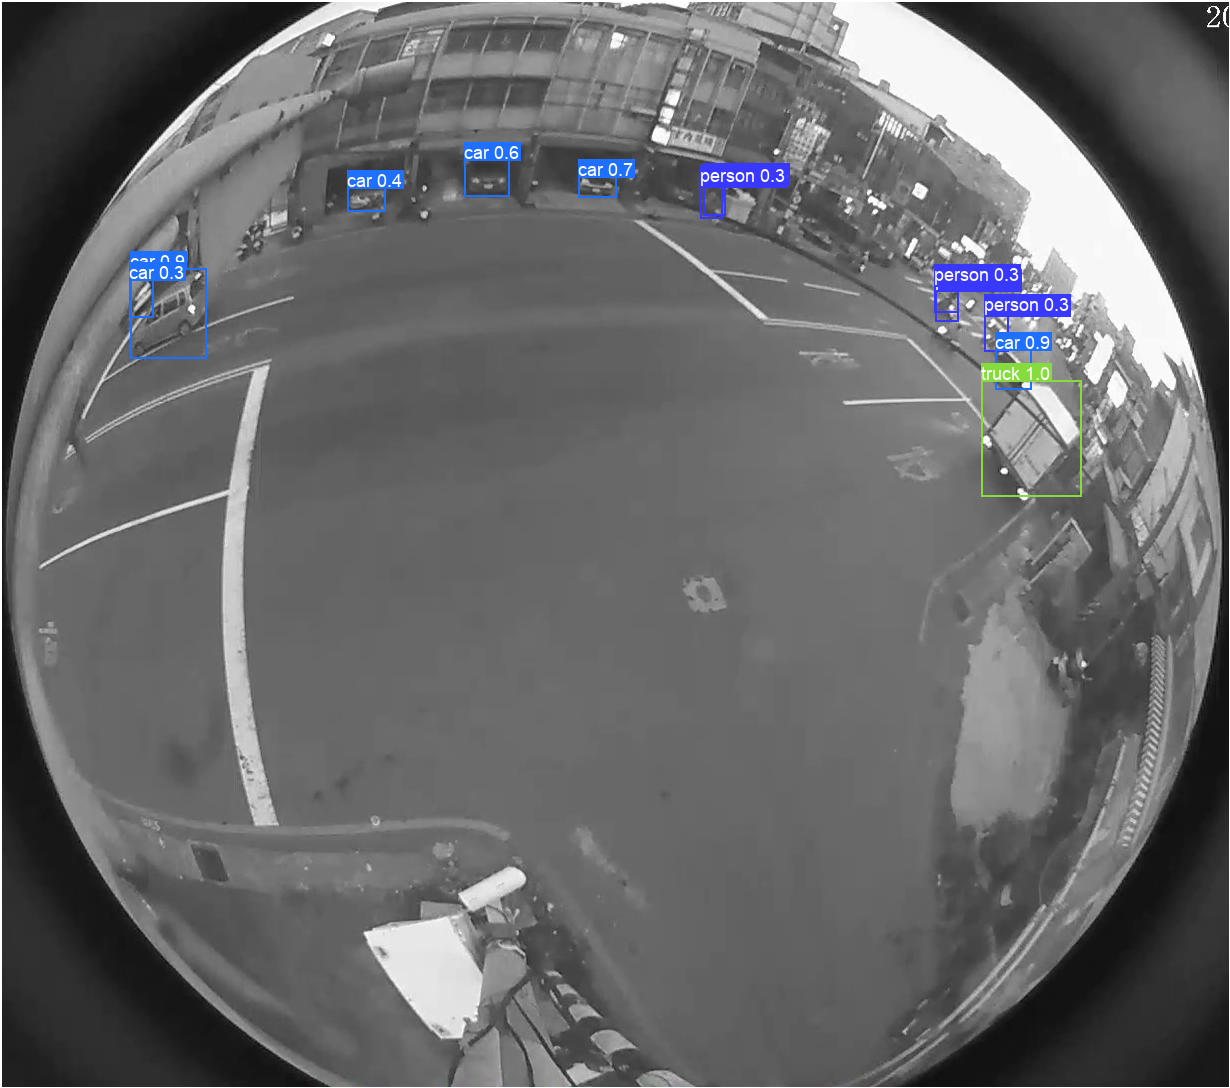

In [11]:
# get predictions
cls = np.array([pred["category_id"] for pred in preds if pred["image_id"] == idx])
bboxes = np.array([pred["bbox"] for pred in preds if pred["image_id"] == idx])
confs = np.array([pred["score"] for pred in preds if pred["image_id"] == idx])
names = {0: 'person', 2: 'car', 3: 'motorcycle', 5: 'bus', 7: 'truck'}
plot_images(img, cls, bboxes, confs, names)